# Load Data

In [ ]:
!pip install recipe-scrapers
!pip install pattern
!pip install wordcloud

In [ ]:
# Resources
# https://medium.com/swlh/building-a-content-based-food-recommendation-engine-df2ac7d08129
# https://towardsdatascience.com/building-a-food-recommendation-system-90788f78691a
# https://www.marketingaiinstitute.com/blog/4-conversational-ai-metrics-how-to-measure-ai-chatbot-performance

# https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831
# https://towardsdatascience.com/how-to-build-a-restaurant-recommendation-system-using-latent-factor-collaborative-filtering-ffe08dd57dca
# https://www.algolia.com/blog/ai/the-anatomy-of-high-performance-recommender-systems-part-1/
# https://www.datacamp.com/community/tutorials/recommender-systems-python

# https://apify.com/dtrungtin/allrecipes-scraper
# https://github.com/tropicalmentat/ingredients_extraction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import random
from random import uniform

import nltk
from recipe_scrapers import scrape_me

# Load Data

In [ ]:
# Save copy of this folder as shortcut in your drive (My drive folder) so mount can be done succesufully
# https://drive.google.com/drive/folders/1V1f40GOu780QALnMXpjbC_sDLVjzkR-o?usp=sharing
# It contains allrecipes 5 datasets [breakfast, lunch, dinner, dessert, snack]

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data prep

Data is loaded from different sources, prepped, then saved. Skip this part and load data directly since this step is already done.

In [ ]:
# import pandas as pd

# df_meals = pd.DataFrame()
# for meal_type in ['breakfast', 'lunch', 'dinner', 'snack', 'dessert']:
#     df_meal = pd.read_json('/content/drive/MyDrive/NLP Datasets/allrecipes/' + meal_type + '.json')
#     df_meal['meal type'] = meal_type
#     df_meals = df_meals.append(df_meal.head(200), ignore_index=True)
#     df_meals

In [ ]:
# import sys
# sys_num = sys.getrecursionlimit()
# sys.setrecursionlimit(sys_num * 5)

# Receipes = []
# df_m = pd.DataFrame(columns=["title", "total_time", "prep", "cook", "yields", "ingredients", "instructions", "calories", "nutrients", "rating", "make_it_again", "image", "meal type"])

# for i, recipe in tqdm(df_meals.iterrows(), total=df_meals.shape[0]):
#   recipe_inst = scrape_me(recipe['url'])
  
#   try:  # Some recipes do not have neutrients and throw error
#     df_m = df_m.append({
#       "title": recipe_inst.title(),
#       "total_time":  recipe_inst.total_time(),
#       "prep": recipe['prep'],
#       "cook": recipe['cook'],
#       "yields": recipe_inst.yields(),
#       "ingredients": recipe_inst.ingredients(),
#       "ingredients text": recipe['ingredients],
#       "instructions": recipe_inst.instructions(),
#       "calories": recipe['calories'],
#       "nutrients": recipe_inst.nutrients(),
#       "rating": recipe['rating'],
#       "make_it_again": random.randint(1, 100),
#       "image": recipe_inst.image(),
#       "meal type": recipe['meal type']
#     }, ignore_index=True)
#   except:
#     print()
#     print(recipe)
#     df_m = df_m.append({
#       "title": recipe_inst.title(),
#       "total_time":  recipe_inst.total_time(),
#       "prep": recipe['prep'],
#       "cook": recipe['cook'],
#       "yields": recipe_inst.yields(),
#       "ingredients": recipe_inst.ingredients(),
#       "ingredients text": recipe['ingredients],
#       "instructions": recipe_inst.instructions(),
#       "calories": recipe['calories'],
#       "rating": recipe['rating'],
#       "make_it_again": random.randint(1, 100),
#       "image": recipe_inst.image(),
#       "meal type": recipe['meal type']
#     }, ignore_index=True)

# sys.setrecursionlimit(sys_num)

# df_m

In [ ]:
# df_m.to_json('/content/drive/MyDrive/NLP Datasets/dataset_all.json')

In [ ]:
# ids = df_m["title"]
# df_m[ids.isin(ids[ids.duplicated()])]

In [ ]:
# df_m.drop_duplicates(subset ="title", keep = False, inplace = True)
# df_m.reset_index(inplace=True, drop=True)
# df_m.to_json('/content/drive/MyDrive/NLP Datasets/dataset_all_deduplicate.json')

## Load prepped data

In [ ]:
with open('/content/drive/MyDrive/NLP Datasets/measurements.txt',"r") as measurements_file:
  measurements = [wd.strip('\n') for wd in measurements_file.readlines()]

In [ ]:
df_all = pd.read_json('/content/drive/MyDrive/NLP Datasets/dataset_all_deduplicate.json')
meal_types = ['breakfast', 'lunch', 'dinner', 'snack', 'dessert']
df_all.head(3)

,title,total_time,prep,cook,yields,ingredients,ingredients text,instructions,calories,nutrients,rating,make_it_again,image,meal type,url
0,Breakfast Cups,30,10 mins,20 mins,18 item(s),"[cooking spray, 18 refrigerated biscuits (unba...","cooking spray, 18 refrigerated biscuits (unbak...",Preheat oven to 400 degrees F (200 degrees C)....,190,"{'calories': '190.4 calories', 'carbohydrateCo...",4.268966,82,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/233747/break...
1,Easy Shakshuka,45,10 mins,35 mins,4 serving(s),"[1 tablespoon olive oil, 2 cloves garlic, minc...","1 tablespoon olive oil, 2 cloves garlic, mince...",Heat the vegetable oil in a deep skillet over ...,294,"{'calories': '293.5 calories', 'carbohydrateCo...",4.282609,2,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/190276/easy-...
2,Lemon-Ricotta Cornmeal Waffles,30,10 mins,20 mins,4 serving(s),"[1 cup all-purpose flour, ½ cup cornmeal, ¼ cu...","1 cup all-purpose flour, ½ cup cornmeal, ¼ cup...",Preheat a waffle iron according to manufacture...,406,"{'calories': '406.1 calories', 'carbohydrateCo...",4.800000,27,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/274974/lemon...


# Feature Engineering

## Cleaning

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import scipy.sparse
from sklearn.pipeline import FeatureUnion
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
import gensim.corpora 
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import unicodedata
from pattern.text.en import singularize
from sklearn.feature_extraction import DictVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
ingredients = np.array(df_all['ingredients text'])
ingredients_comma = np.array(df_all['ingredients'])
instructions_init = np.array(df_all['instructions'])
tokenizer = RegexpTokenizer("[\w']+")
random.seed(123)

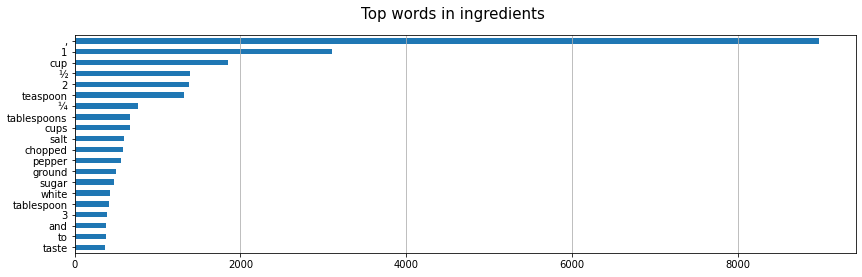

In [ ]:
ingredients = [re.sub(r"\([^()]*\)", "", ingredient) for ingredient in ingredients] # remove brackets and strings inside
lst_tokens = nltk.tokenize.word_tokenize(' '.join(ingredients))
dic_words_freq = nltk.FreqDist(lst_tokens)
terms = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
extra_stop_words_ingredients = list(terms.head(20)['Word'])
extra_stop_words_ingredients.remove(",")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
fig.suptitle("Top words in ingredients", fontsize=15)

terms.set_index("Word").iloc[:20,:].sort_values(by="Freq").plot(
                  kind="barh", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()

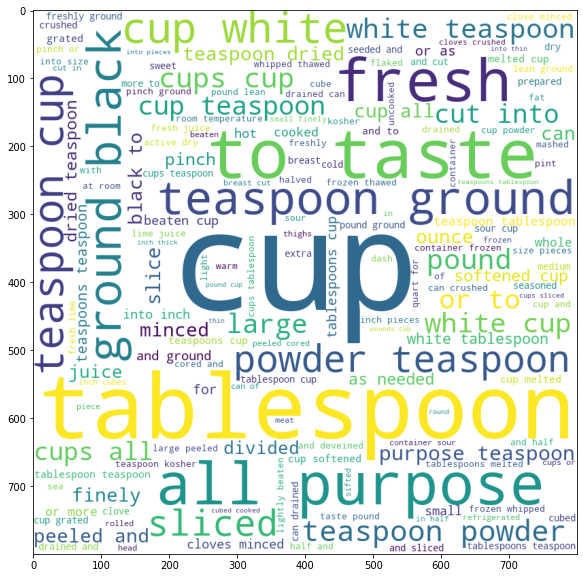

In [ ]:
extra_stop_words_ingredients = ['teaspoons', 'tablespoons', 'chopped', 'ground', 'minced', 'cups', 'extract', 'shredded', 'and', 'or', 'all-purpose', 'all purpose', 'allpurpose', 'cloves', 'to taste',
                                'slices', 'sliced', 'shredded', 'of', 'sizes', 'sized', 'large', 'small', 'big', 'medium', 'can', 'cut into', 'finely', 'whole', 'peeled', 'plum', 'with juice',
                                'refrigerated', 'unbaked', 'uncooked', 'ounces', 'frozen', 'black', 'white', 'mild', 'hot', 'cold', 'thawed', 'whipped', 'container', 'needed', 'thighs', 'diced',
                                'cracked', 'dried', 'powdered', 'warm', 'flaked', 'melted', 'brown', 'grated', 'thin', 'dried', 'dry', 'more', 'degree', 'root', 'fresh', 'cored', 'cores', 'lean',
                                'fat', 'halved', 'half', 'crushed', 'plain', 'cubed', 'cubes', 'sifted', 'golden', 'distilled', 'sweet', 'sour', 'deep', 'italian', 'active', 'condensed', 'lightly', 'beaten'
                                'sea', 'breast', 'drained', 'deveined', 'mashed', 'rolled', 'evaporated', 'for', 'divided', 'seasoned', 'degree', 'f45', 'roma', 'cherry', 'seeded', 'prepared', 'meat', 'head',
                                'kosher', 'thick', 'degree', 'degrees', 'freshly', 'room temperature', 'half', 'softened'] + measurements
extra_stop_words_ingredients.remove('breadth')

wc_stops = [term for term in terms['Word'] if not term in ''.join(extra_stop_words_ingredients)]
plt.figure(figsize=(16,10))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wc_stops,
                min_font_size = 10).generate(' '.join(lst_tokens))
plt.imshow(wordcloud)

In [ ]:
def clean_ingredient(ingredient):
  ingredient = re.sub(r'[^\w\s]', '', ingredient.lower().strip())
  ingredient = ingredient.replace("\\p{No}+", "") # remove fractions
  ingredient = tokenizer.tokenize(ingredient)
  ingredient = np.array([token for token in ingredient if not (token.isdigit() or isinstance(unicodedata.numeric(token[0], ''), float))])
  ingredient = np.array([token for token in ingredient if not token in (' '.join(extra_stop_words_ingredients))])
  ingredient = np.array([singularize(token) for token in ingredient])
  ingredient = ' '.join(ingredient[-2:])
  ingredient = ingredient.replace('pitum', 'pita')
  ingredient = ingredient.replace('flmy', 'flour')
  ingredient = ingredient.replace('ricottum', 'ricotta')
  ingredient = ingredient.replace('olife', 'olive')
  return ingredient

filtered_ingredients_list = []
for ingredients in ingredients_comma:
  filtered_ingredients = np.vectorize(clean_ingredient)([ingredients])[0]
  if '' in filtered_ingredients:
    list_ingredients = filtered_ingredients.tolist()
    list_ingredients.remove('')
    filtered_ingredients = np.array(list_ingredients)
  if 'salt pepper' in filtered_ingredients:
    list_ingredients = filtered_ingredients.tolist()
    list_ingredients.remove('salt pepper')
    list_ingredients.append('salt')
    list_ingredients.append('pepper')
    filtered_ingredients = np.array(list_ingredients)
  filtered_ingredients_list.append(filtered_ingredients)

filtered_ingredients_list = np.array(filtered_ingredients_list)

print(ingredients_comma[0:3])
print()
print(filtered_ingredients_list[0:3])

[list(['cooking spray', '18 refrigerated biscuits (unbaked)', '8 ounces breakfast sausage', '7 large eggs', '½ cup milk', 'salt and ground black pepper to taste', '1 cup mild shredded Cheddar cheese'])
 list(['1 tablespoon olive oil', '2 cloves garlic, minced', '1 onion, cut into 2 inch pieces', '1 green bell pepper, cut into 2 inch pieces', '1 (28 ounce) can whole peeled plum tomatoes with juice', '1 teaspoon paprika, or to taste', '2 slices pickled jalapeno pepper, finely chopped', '4 eggs', '4 (6 inch) pita bread'])
 list(['1 cup all-purpose flour', '½ cup cornmeal', '¼ cup white sugar', '1 ½ teaspoons baking powder', '½ teaspoon baking soda', '¼ teaspoon salt', '¾ cup half-and-half', '½ cup ricotta cheese', '2 large eggs', '2 tablespoons melted butter', '1 teaspoon lemon extract', 'cooking spray'])]

[array(['cooking spray', 'biscuit', 'breakfast sausage', 'egg', 'milk',
       'cheddar cheese', 'salt', 'pepper'], dtype='<U17')
 array(['olive oil', 'garlic', 'onion', 'bell pepper',

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


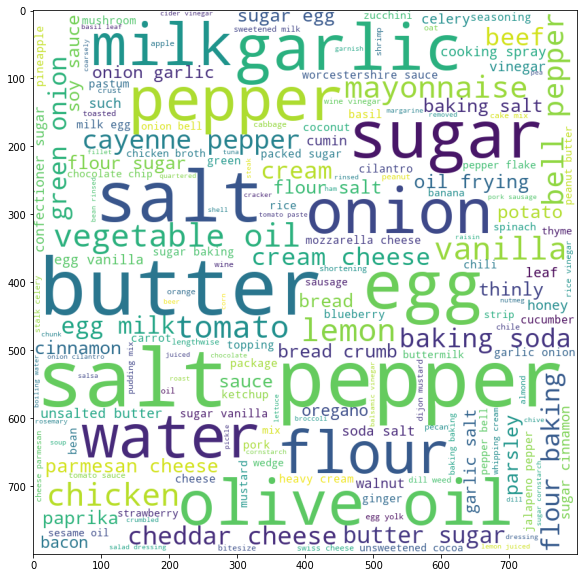

In [ ]:
wc_stops = [term for term in terms['Word'] if term in ''.join(extra_stop_words_ingredients)]
plt.figure(figsize=(16,10))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wc_stops,
                min_font_size = 10).generate(' '.join(np.concatenate(filtered_ingredients_list).ravel().tolist()))
plt.imshow(wordcloud)

In [ ]:
df_all['ingredients filtered'] = filtered_ingredients_list

filtered_ingredients_list_text = []
for i in filtered_ingredients_list:
  filtered_ingredients_list_text.append(','.join(i))

df_all['ingredients filtered text'] = filtered_ingredients_list_text

In [ ]:
def most_common_vocab(vocab, n):
  vocabulary = nltk.FreqDist()
  for ingredients in vocab:
      ingredients = ingredients.split(',')
      vocabulary.update(ingredients)
  for word, frequency in vocabulary.most_common(n):
      print(f'{word}: {frequency}')
  return vocabulary

vocabulary = most_common_vocab(df_all['ingredients filtered text'], 20)
not_common_ingredients = list(filter(lambda x: x[1]<=3, vocabulary.items()))
not_common_ingredients = [x[0] for x in not_common_ingredients]

salt: 560
sugar: 398
pepper: 330
egg: 302
butter: 277
flour: 257
garlic: 228
onion: 203
milk: 199
vanilla: 142
olive oil: 141
water: 141
baking: 100
vegetable oil: 92
cinnamon: 86
mayonnaise: 79
bell pepper: 76
cayenne pepper: 69
baking soda: 67
cheddar cheese: 65


In [ ]:
common_ingredients = list(filter(lambda x: x[1]>3, vocabulary.items()))
common_ingredients = [x[0] for x in common_ingredients]
print('Used Ingredients: ' + str(len(common_ingredients)))

Used Ingredients: 258


In [ ]:
filtered_ingredients_list[0:3]

array([array(['cooking spray', 'biscuit', 'breakfast sausage', 'egg', 'milk',
       'cheddar cheese', 'salt', 'pepper'], dtype='<U17'),
       array(['olive oil', 'garlic', 'onion', 'bell pepper', 'tomato', 'paprika',
       'jalapeno pepper', 'egg', 'pita bread'], dtype='<U15'),
       array(['flour', 'cornmeal', 'sugar', 'baking', 'baking soda', 'salt',
       'halfandhalf', 'ricotta cheese', 'egg', 'butter', 'lemon',
       'cooking spray'], dtype='<U14')], dtype=object)

In [ ]:
filtered_ingredients_list_common = np.array([[ingredient for ingredient in ingredients if ingredient not in not_common_ingredients] for ingredients in filtered_ingredients_list])
filtered_ingredients_list_common[0:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([list(['cooking spray', 'egg', 'milk', 'cheddar cheese', 'salt', 'pepper']),
       list(['olive oil', 'garlic', 'onion', 'bell pepper', 'tomato', 'paprika', 'jalapeno pepper', 'egg']),
       list(['flour', 'cornmeal', 'sugar', 'baking', 'baking soda', 'salt', 'halfandhalf', 'ricotta cheese', 'egg', 'butter', 'lemon', 'cooking spray'])],
      dtype=object)

In [ ]:
df_all['ingredients filtered'] = filtered_ingredients_list_common

filtered_ingredients_list_text_common = []
for i in filtered_ingredients_list_common:
  filtered_ingredients_list_text_common.append(','.join(i))

df_all['ingredients filtered text'] = filtered_ingredients_list_text_common
df_all.head(3)

,title,total_time,prep,cook,yields,ingredients,ingredients text,instructions,calories,nutrients,rating,make_it_again,image,meal type,url,ingredients filtered,ingredients filtered text
0,Breakfast Cups,30,10 mins,20 mins,18 item(s),"[cooking spray, 18 refrigerated biscuits (unba...","cooking spray, 18 refrigerated biscuits (unbak...",Preheat oven to 400 degrees F (200 degrees C)....,190,"{'calories': '190.4 calories', 'carbohydrateCo...",4.268966,82,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/233747/break...,"[cooking spray, egg, milk, cheddar cheese, sal...","cooking spray,egg,milk,cheddar cheese,salt,pepper"
1,Easy Shakshuka,45,10 mins,35 mins,4 serving(s),"[1 tablespoon olive oil, 2 cloves garlic, minc...","1 tablespoon olive oil, 2 cloves garlic, mince...",Heat the vegetable oil in a deep skillet over ...,294,"{'calories': '293.5 calories', 'carbohydrateCo...",4.282609,2,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/190276/easy-...,"[olive oil, garlic, onion, bell pepper, tomato...","olive oil,garlic,onion,bell pepper,tomato,papr..."
2,Lemon-Ricotta Cornmeal Waffles,30,10 mins,20 mins,4 serving(s),"[1 cup all-purpose flour, ½ cup cornmeal, ¼ cu...","1 cup all-purpose flour, ½ cup cornmeal, ¼ cup...",Preheat a waffle iron according to manufacture...,406,"{'calories': '406.1 calories', 'carbohydrateCo...",4.800000,27,https://imagesvc.meredithcorp.io/v3/mm/image?u...,breakfast,https://www.allrecipes.com/recipe/274974/lemon...,"[flour, cornmeal, sugar, baking, baking soda, ...","flour,cornmeal,sugar,baking,baking soda,salt,h..."


In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(' '.join(instructions_init))
dic_words_freq = nltk.FreqDist(lst_tokens)
terms = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
extra_stop_words_instructions = list(terms.head(20)['Word'])
extra_stop_words_instructions

['.',
 ',',
 'and',
 'the',
 'a',
 'in',
 'to',
 'until',
 'with',
 'minutes',
 'of',
 'into',
 'degrees',
 'bowl',
 'over',
 'for',
 'oven',
 'mixture',
 'heat',
 ';']

In [ ]:
ps = nltk.stem.porter.PorterStemmer()
instructions_list = []
for instruction in instructions_init:
  instruction = re.sub(r'[^\w\s]', '', instruction.lower().strip())
  instruction = instruction.replace("\\p{No}+", "") # remove fractions
  instruction = tokenizer.tokenize(instruction)
  instruction = [token for token in instruction if not (token.isdigit() or isinstance(unicodedata.numeric(token[0], ''), float))]
  instruction = [token for token in instruction if token not in stop_words]
  instruction = [token for token in instruction if len(token) > 2]
  instruction = [ps.stem(token) for token in instruction]
  instruction = np.array([token for token in instruction if not token in (' '.join(extra_stop_words_instructions))])
  instruction = ' '.join(instruction)
  instructions_list.append(instruction)
instructions = np.array(instructions_list)
instructions[0]

'preheat greas muffin cup cook spray roll biscuit dough lightli flour surfac form round place round prepar muffin cup press base side form dough cup cook stir sausag skillet mediumhigh brown cook drain fat spoon sausag dough cup whisk egg milk salt pepper togeth wellbeaten pour egg dough cup fill top biscuit dough sprinkl cheddar chees top egg bake preheat egg set biscuit dough golden'

## Transformations and features

In [ ]:
r = []
for c, i in enumerate(df_all['ingredients filtered text']):
  temp = df_all.iloc[c]['ingredients filtered'].copy()
  for j in i.split(','):
    if ' ' in j:
      temp.append(j.split(' ')[0])
      temp.append(j.split(' ')[1])
  r.append(temp)

wv2 = Word2Vec(r, min_count = 1, size = 100, window = 5)

In [ ]:
tfidf = TfidfVectorizer()
X_ingre_tfidf = tfidf.fit_transform(common_ingredients).todense() 

cv_ingre = CountVectorizer()
X_ingre_cv = cv_ingre.fit_transform(common_ingredients).todense()

wv = Word2Vec(df_all['ingredients filtered'], min_count = 1, size = 100, window = 5)


ingredients = df_all['ingredients filtered text']

tfidf_recipes = TfidfVectorizer()
X_ingredients_tfidf = tfidf_recipes.fit_transform(ingredients).todense() 

cv = CountVectorizer()
X_ingredients_cv = cv.fit_transform(ingredients).todense() 

instructions = instructions
d2v = Doc2Vec([TaggedDocument(s.split(),[i]) for i, s in enumerate(instructions)], vector_size=100)
X_instructions_d2v = np.array([d2v[i] for i in range(len(instructions))])

total_time = np.array(df_all['total_time'])
total_time_norm = total_time / np.linalg.norm(total_time)

X_tfidf_d2v_inger_instr_time = np.hstack([X_ingredients_tfidf, X_instructions_d2v, np.reshape(total_time_norm, (-1,1))]) # append horizontally
X = X_tfidf_d2v_inger_instr_time

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
df = df_all.copy()
# X_train, X_test, y_train, y_test = train_test_split(X,df['meal type'],test_size=0.2, random_state=0)

Clustring with K = 1
Clustring with K = 2
Clustring with K = 3
Clustring with K = 4
Clustring with K = 5
Clustring with K = 6
Clustring with K = 7
Clustring with K = 8
Clustring with K = 9
Clustring with K = 10
Clustring with K = 11
Clustring with K = 12
Clustring with K = 13
Clustring with K = 14
Clustring with K = 15
Clustring with K = 16
Clustring with K = 17
Clustring with K = 18
Clustring with K = 19
Clustring with K = 20
Clustring with K = 21
Clustring with K = 22
Clustring with K = 23
Clustring with K = 24
Clustring with K = 25
Clustring with K = 26
Clustring with K = 27
Clustring with K = 28
Clustring with K = 29
Clustring with K = 30
Clustring with K = 31
Clustring with K = 32
Clustring with K = 33
Clustring with K = 34


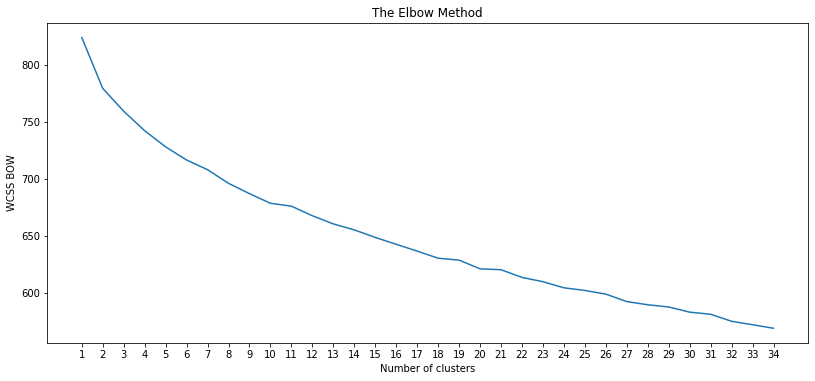

In [ ]:
def Graph(t,x,y,y_cluster,ticks):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.plot(ticks, y_cluster)
    plt.xticks(ticks)

wcss = []
n_clusters = range(1,35)

for i in n_clusters :
    print("Clustring with K = " + str(i))
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_ingredients_tfidf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(30,20))
plt.subplot(3, 2, 1)
Graph("The Elbow Method","Number of clusters","WCSS BOW",wcss,n_clusters)
plt.show()

In [ ]:
km = KMeans(n_clusters=10, init='k-means++', random_state=42)
km.fit(X_ingre_tfidf)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = common_ingredients
cluster_map['cluster'] = km.labels_
cluster_map[cluster_map.cluster == 0]

,data_index,cluster
0,cooking spray,0
6,olive oil,0
10,tomato,0
13,flour,0
17,baking soda,0
20,butter,0
23,flour tortilla,0
26,margarine,0
27,potato quartered,0
35,vegetable oil,0


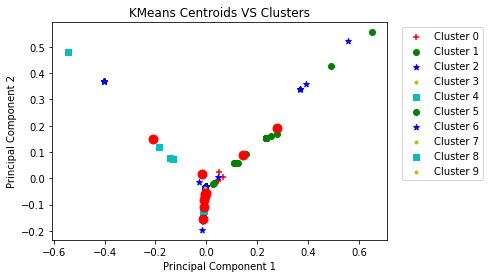

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_ingre_tfidf)
data2D = pca.transform(X_ingre_tfidf)

colors = ['r', 'g', 'b', 'y', 'c', 'g', 'b', 'y', 'c', 'y']
legend = []
markers = ['+', 'o', '*', '.', ',', 'o', '*', '.', ',', '.']
for i in range(0, 10):
  in_cluster = cluster_map['cluster'] == i
  index = cluster_map.index
  legend.append(plt.scatter(data2D[index[in_cluster],0],data2D[index[in_cluster],1],c=colors[i],marker=markers[i]))
plt.legend(legend,['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6','Cluster 7', 'Cluster 8','Cluster 9'],bbox_to_anchor= (1.03, 1))

centroids = pca.transform(km.cluster_centers_)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'r')
plt.title("KMeans Centroids VS Clusters")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

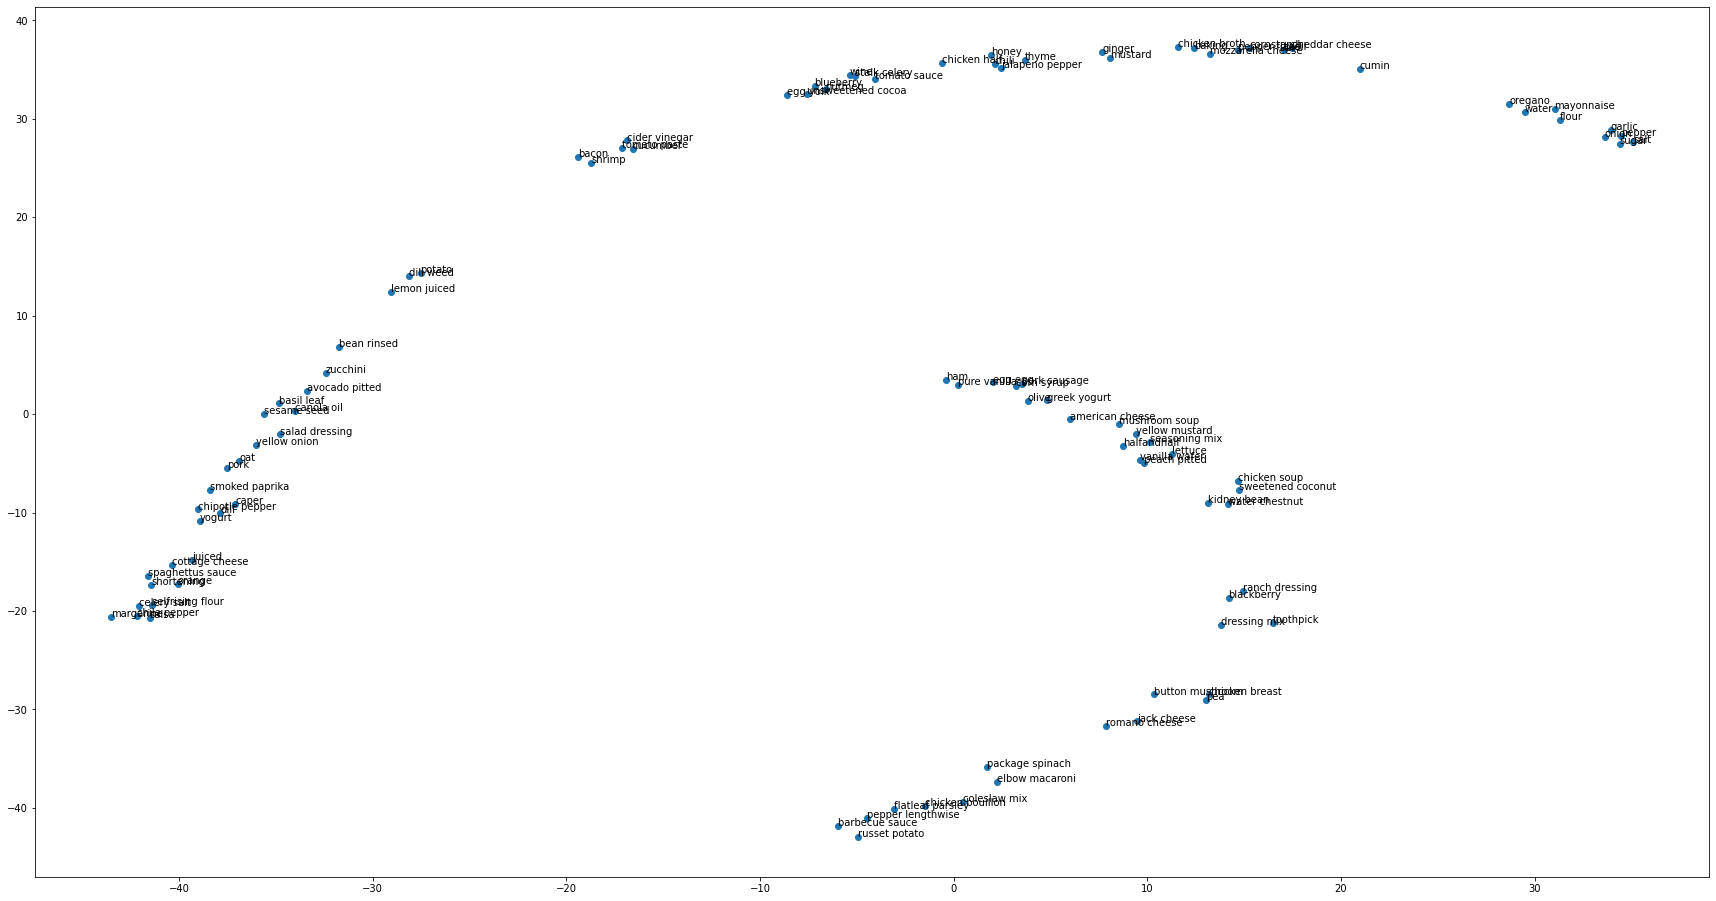

In [ ]:
vocab_list = list(wv.wv.vocab)
vocab_val = wv.wv[vocab_list]

tsne = TSNE(perplexity=10, random_state=123).fit_transform(vocab_val)
df_ingre_tsne = pd.DataFrame(tsne, index=vocab_list, columns=['x', 'y'])

df_ingre_tsne_sample = df_ingre_tsne.sample(n=100, random_state=0)

fig = plt.figure(figsize=(30,16))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_ingre_tsne_sample['x'], df_ingre_tsne_sample['y'])
for word, pos in df_ingre_tsne_sample.iterrows():
  ax.annotate(word, pos)
plt.show()

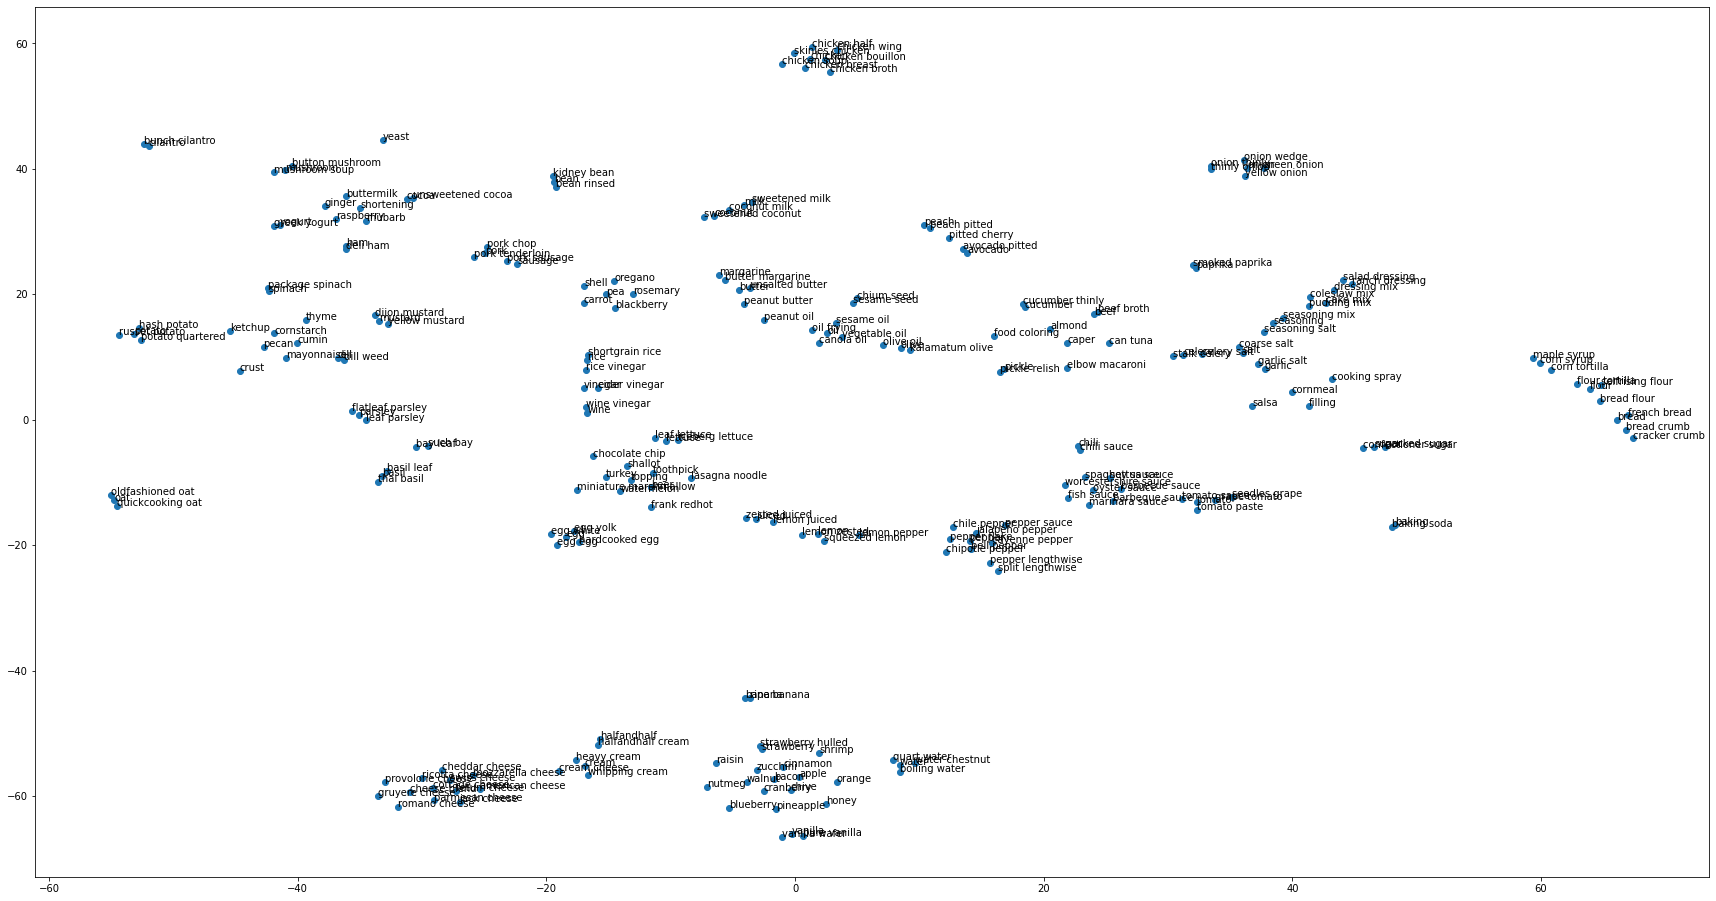

In [ ]:
vocab_list = list(wv.wv.vocab)
vocab_val = wv.wv[vocab_list]

tsne = TSNE(perplexity=3, random_state=123).fit_transform(X_ingre_cv)
df_ingre_tsne = pd.DataFrame(tsne, index=vocab_list, columns=['x', 'y'])

df_ingre_tsne_sample = df_ingre_tsne.sample(n=250, random_state=0)

fig = plt.figure(figsize=(30,16))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_ingre_tsne_sample['x'], df_ingre_tsne_sample['y'])
for word, pos in df_ingre_tsne_sample.iterrows():
  ax.annotate(word, pos)
plt.show()

Similar words to salt


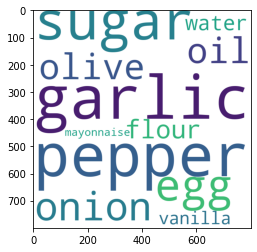

In [ ]:
import math
x = wv.wv.most_similar('salt', topn=10)
words = ''
for word, c in x:
  words += ((word+' ') *(math.floor(c*2)))

print('Similar words to salt')
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)
plt.imshow(wordcloud)

Clustring with K = 1
Clustring with K = 2
Clustring with K = 3
Clustring with K = 4
Clustring with K = 5
Clustring with K = 6
Clustring with K = 7
Clustring with K = 8
Clustring with K = 9


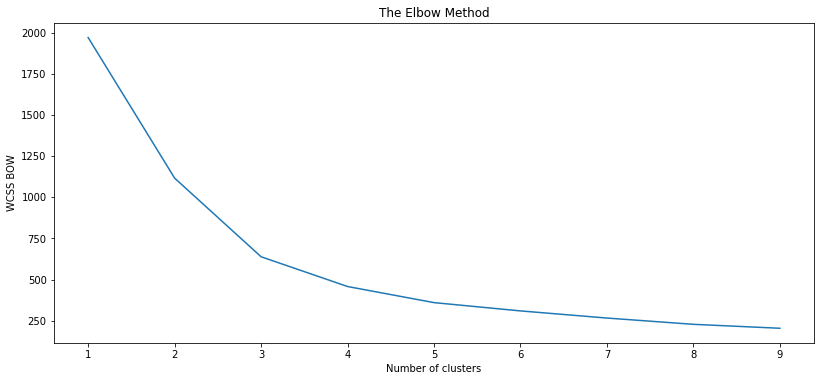

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_ingredients_cv)
data2D = pca.transform(X_ingredients_cv)

wcss = []
n_clusters = range(1,10)

for i in n_clusters :
    print("Clustring with K = " + str(i))
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data2D)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(30,20))
plt.subplot(3, 2, 1)
Graph("The Elbow Method","Number of clusters","WCSS BOW",wcss,n_clusters)
plt.show()

In [ ]:
import math
# c = math.floor(np.array([len(i) for i in df['ingredients filtered']]).mean()/2) + 1
c = 3

km_meals = KMeans(n_clusters=c, init='k-means++', random_state=42)
km_meals.fit(X_ingredients_cv)

df['cluster by ingredient'] = km_meals.labels_
# df.groupby(['cluster by ingredient', 'meal type']).count()

clust = 0
clust_data = df[df['cluster by ingredient'] == clust]

Mean num of ingredients: 9

sugar: 236
flour: 168
salt: 158
egg: 140
butter: 125
vanilla: 98
milk: 94
baking: 87
baking soda: 67
cinnamon: 56
vegetable oil: 33
water: 30
walnut: 19
lemon: 18
unsalted butter: 18
unsweetened cocoa: 18
confectioner sugar: 17
packed sugar: 17
blueberry: 14
buttermilk: 13


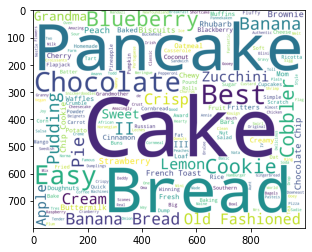

Mean num of ingredients: 9

salt: 269
pepper: 268
garlic: 188
onion: 158
olive oil: 116
bell pepper: 74
cayenne pepper: 64
sugar: 61
egg: 60
green onion: 49
tomato: 48
mayonnaise: 47
water: 46
butter: 45
oregano: 44
paprika: 39
flour: 39
lemon: 34
parmesan cheese: 33
cumin: 31


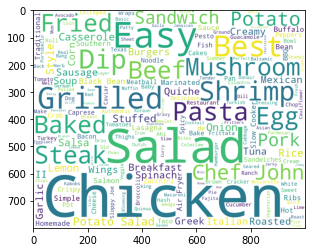

Mean num of ingredients: 5

salt: 133
butter: 107
egg: 102
sugar: 101
milk: 82
water: 65
pepper: 60
flour: 50
onion: 44
vanilla: 44
cream cheese: 44
garlic: 40
cheddar cheese: 39
mayonnaise: 31
bread crumb: 30
vegetable oil: 28
cream: 24
cinnamon: 23
parmesan cheese: 23
olive oil: 22


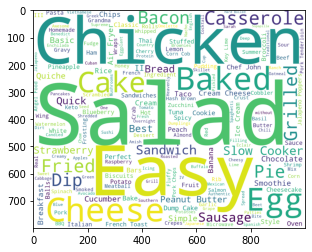

In [ ]:
for i in range(c):
  clust = i
  clust_data = df[df['cluster by ingredient'] == clust]

  print('Mean num of ingredients: ' + str(math.floor(np.array([len(i) for i in clust_data['ingredients filtered']]).mean())))
  print()
  x = clust_data['ingredients filtered text']
  y = most_common_vocab(x, 20).items()
  wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(clust_data['title'].tolist()))
  plt.imshow(wordcloud)
  plt.show()

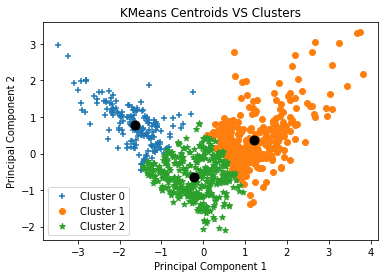

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_ingredients_cv)
data2D = pca.transform(X_ingredients_cv)

# colors = ['r', 'g', 'b', 'y', 'c', 'k', 'b', 'y', 'c', 'y']
legend = []
markers = ['+', 'o', '*', ',', '.', 'o', '*', '.', ',', '.']
for i in range(0, c):
  in_cluster = df['cluster by ingredient'] == i
  index = df.index
  legend.append(plt.scatter(data2D[index[in_cluster],0],data2D[index[in_cluster],1],marker=markers[i]))
plt.legend(legend,['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6','Cluster 7', 'Cluster 8','Cluster 9'])

centroids = pca.transform(km_meals.cluster_centers_)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.title("KMeans Centroids VS Clusters")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

s = cv.transform(np.array(['pasta,tomato'])).todense()
p = km_meals.predict(s)[0]

t = cv.transform(df[df['cluster by ingredient'] == p]['ingredients filtered text']).todense()
closest, _ = pairwise_distances_argmin_min(s, t, metric='cosine')
print(np.array(df[df['cluster by ingredient'] == p])[closest[0]])
print()
t = cv.transform(df['ingredients filtered text']).todense()
closest, _ = pairwise_distances_argmin_min(s, t, metric='cosine')
print(np.array(df)[closest[0]])
print()


["Emily's Excellent Taco Casserole" 35 '10 mins' '25 mins' '4 serving(s)'
 list(['6 cups corn tortilla chips', '2 cups vegetarian chili with beans', '1 cup shredded Cheddar cheese', '2 cups shredded lettuce', '2 roma (plum) tomatoes, chopped', '½ cup salsa', '¼ cup sour cream'])
 '6 cups corn tortilla chips, 2 cups vegetarian chili with beans, 1 cup shredded Cheddar cheese, 2 cups shredded lettuce, 2 roma (plum) tomatoes, chopped, ½ cup salsa, ¼ cup sour cream'
 'Preheat the oven to 350 degrees F (175 degrees C).\nPlace chips in the bottom of a 9 inch square baking dish. Pour chili straight from the can over the chips. Sprinkle shredded cheese over the top.\nBake for 20 to 25 minutes in the preheated oven, until chili is bubbling and cheese is melted. Top with lettuce, tomato, sour cream and salsa in the pan, or after serving (if people are picky).'
 '477'
 {'calories': '476.9 calories', 'carbohydrateContent': '48.8 g', 'cholesterolContent': '42.5 mg', 'fatContent': '24 g', 'fiberConte

**Classification**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from copy import deepcopy
from sklearn.decomposition import LatentDirichletAllocation


from sklearn.model_selection import train_test_split

df_x = df['ingredients text']
df_y = df['meal type']


X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

transformations = [
                   #[('tran', CountVectorizer())],
                   [('tran1', CountVectorizer(ngram_range=(1,2))), ('tran2', TfidfTransformer(use_idf=True))]
                   #[('tran', CountVectorizer(analyzer='word', ngram_range=(2, 2)))],
                   #[('tran1', CountVectorizer()), ('tran2', preprocessing.FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), ('tran3', LinearDiscriminantAnalysis())]
                  ]
classifiers = [
               [('clf', SGDClassifier(random_state=0))],
               [('clf', KNeighborsClassifier())],
               [('clf', DecisionTreeClassifier(random_state=0))],
               [('clf', svm.SVC(random_state=0))]
              #  [('clf', MLPClassifier(hidden_layer_sizes=(50,50,50,50), random_state=0))],
              #  [('clf', RandomForestClassifier(n_estimators=1000, random_state=0))],
              #  [('clf', svm.SVC(decision_function_shape='ovo'))],
              #  [('clf', svm.LinearSVC())]
              ]
models = []
for transform in transformations:
  for classifier in classifiers:
    text_clf = Pipeline(transform + classifier)
    models.append(deepcopy(text_clf))

# Evaluation

In [ ]:
from sklearn.model_selection import KFold
 
kf = KFold(n_splits=10)
for text_clf in models:
  scores = []
  for train, test in kf.split(X_train):
    model = text_clf.fit(X_train[train], y_train[train])
    scores.append(metrics.accuracy_score(y_train[test], model.predict(X_train[test])))
    # print(metrics.confusion_matrix(y_train.iloc[test].apply(author_Names.index), model.predict(X_train.iloc[test])))

  print("Accuracy: %0.2f%%" %(np.array(scores).mean()*100))
  print('-------------------------------------')

Accuracy: 67.04%
-------------------------------------
Accuracy: 62.01%
-------------------------------------
Accuracy: 50.62%
-------------------------------------
Accuracy: 67.31%
-------------------------------------


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    
    'clf__kernel': ['rbf', 'linear'],
    'clf__gamma': [1e-3, 1e-4],
    'clf__C': [1, 10, 100, 1000],
    'tran2__use_idf': (True, False),
    'tran1__ngram_range': [(1, 1), (1, 2), (2,2)]
}

scorer = metrics.make_scorer(metrics.accuracy_score)
gs_clf = GridSearchCV(deepcopy(models[3]), parameters, cv=10, n_jobs=-1, scoring=scorer)

# Fit and evaluate
gs_clf = gs_clf.fit(X_train, y_train)
print("Training Accuracy: " + str(gs_clf.score(X_train, y_train)))
print("Mean cross-validation Accuracy: " + str(gs_clf.best_score_))

print()
print('Best Parameters')
print('----------------')
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

print()
print('Report')
print('-------')
print(metrics.classification_report(y_train, gs_clf.predict(X_train)))

Training Accuracy: 0.9131614654002713
Mean cross-validation Accuracy: 0.6893372824879674

Best Parameters
----------------
clf__C: 1
clf__gamma: 0.001
clf__kernel: 'linear'
tran1__ngram_range: (1, 1)
tran2__use_idf: True

Report
-------
              precision    recall  f1-score   support

   breakfast       0.89      0.92      0.90       152
     dessert       0.95      0.97      0.96       152
      dinner       0.89      0.95      0.92       151
       lunch       0.93      0.88      0.91       130
       snack       0.91      0.83      0.87       152

    accuracy                           0.91       737
   macro avg       0.91      0.91      0.91       737
weighted avg       0.91      0.91      0.91       737



In [ ]:
print(metrics.classification_report(y_test, gs_clf.predict(X_test)))

              precision    recall  f1-score   support

   breakfast       0.65      0.65      0.65        34
     dessert       0.79      0.88      0.84        43
      dinner       0.58      0.81      0.68        32
       lunch       0.76      0.57      0.65        46
       snack       0.50      0.40      0.44        30

    accuracy                           0.67       185
   macro avg       0.66      0.66      0.65       185
weighted avg       0.67      0.67      0.66       185



In [ ]:
gs_clf.predict(['egg,milk',
                'chicken',
                'oil,chicken,salt,pepper,cheese',
                'bacon,toast,american cheese',
                'bacon,lettuce,tomato',                     # BLT
                'sandwich',
                'chip',
                'butter,sugar',
                'dough,pepproni,tomato sauce,mozzarella',   # pizza
                ])

array(['breakfast', 'dinner', 'dinner', 'breakfast', 'breakfast', 'snack',
       'snack', 'dessert', 'dinner'], dtype=object)

In [ ]:
from sklearn.metrics import cohen_kappa_score, silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from gensim.models import CoherenceModel, LdaModel


silho = silhouette_score(X_ingre_tfidf, cluster_map['cluster'], metric='euclidean')
print('Silhouette ' + str(silho))

Silhouette 0.04834977180319514


In [ ]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora.dictionary import Dictionary

def coherence(New_Ing):
    # Coherence
    dictionary = Dictionary([s.split() for s in New_Ing])
    dictionary.filter_extremes(no_below=2, no_above=0.2)
    #Create dictionary and corpus required for Topic Modeling
    corpus = [dictionary.doc2bow(doc) for doc in [s.split() for s in New_Ing]]
    id2word = dictionary.id2token

    # Loop over num of topics to find the highest coherence
    num_topics = 0
    max_coh = 0
    coherence_list = []
    for i in range(1, 13):
        print(str(i) + ' ', end='')
        lda_model = LdaModel(corpus, num_topics=i, random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=[s.split() for s in New_Ing], dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_list.append(coherence_lda)
        
        if coherence_lda > max_coh:
            max_coh = coherence_lda
            num_topics = i

    print()
    print('Coherence ' + str(max_coh) + ' for ' + str(num_topics) + ' topics')

    # Show graph of coherence per topic
    plt.plot(range(1, len(coherence_list)+1), coherence_list)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title("Coherence plot")
    plt.show()

    return corpus, dictionary, num_topics

Coherence Plot

1 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

2 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

3 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

4 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

5 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

6 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

7 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

8 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

9 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

10 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

11 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

12 

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Coherence 0.8525269656004131 for 1 topics


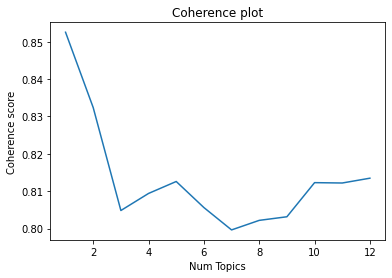

In [ ]:
print("Coherence Plot\n")
corpus, dictionary, num_topics = coherence(common_ingredients)

**Saving the generated models into objects**

In [ ]:
import pickle

# For Classification

# save
with open('classification_model.pkl','wb') as f:
    pickle.dump(gs_clf,f)

# load
with open('classification_model.pkl', 'rb') as f:
    Loaded_Classification_Model = pickle.load(f)

# Loaded_Classification_Model.predict(X_test[0])
#___________________________________________
# For Clustering

# save
with open('clustering_model_inredients.pkl','wb') as f:
    pickle.dump(km,f)
with open('clustering_model_recipes.pkl','wb') as f:
    pickle.dump(km_meals,f)

# load
# with open('clustering_model.pkl', 'rb') as f:
#     Loaded_Clustering_Model = pickle.load(f)

# Loaded_Clustering_Model.predict(X_test[0])

# For transformations
with open('wv.pkl','wb') as f:
    pickle.dump(wv,f)
with open('wv2.pkl','wb') as f:
    pickle.dump(wv2,f)
with open('tfidf.pkl','wb') as f:
    pickle.dump(tfidf,f)
with open('cv_ingredients.pkl','wb') as f:
    pickle.dump(cv_ingre,f)
with open('cv_recipes.pkl','wb') as f:
    pickle.dump(cv,f)

# For dataframe
with open('df_final.pkl','wb') as f:
    pickle.dump(df,f)

**Error Analysis**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

Testing precision: 0.9131614654002713

12 texts has been wrongly classified as breakfast
10 texts has been wrongly classified as lunch
19 texts has been wrongly classified as dinner
8 texts has been wrongly classified as snack
12 texts has been wrongly classified as dessert
12 of breakfast texts has been wrongly classified
5 of lunch texts has been wrongly classified
6 of dinner texts has been wrongly classified
20 of snack texts has been wrongly classified
18 of dessert texts has been wrongly classified




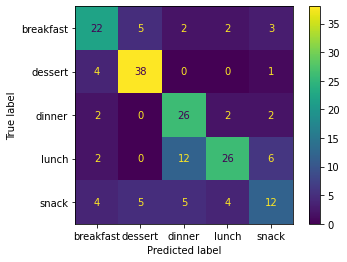

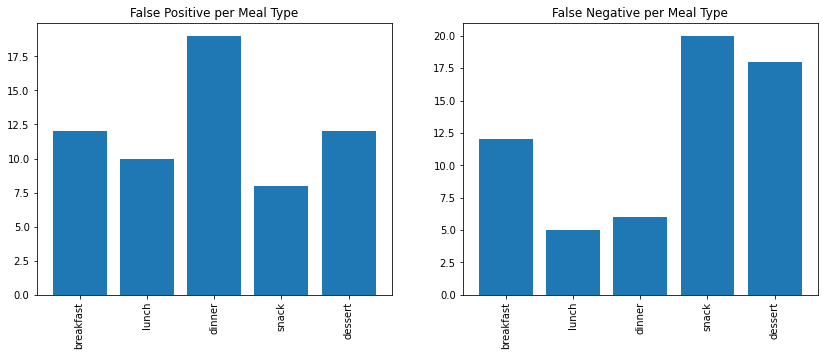

In [ ]:

predicted = gs_clf.predict(X_test)
print("Testing precision: " + str(gs_clf.score(X_train, y_train)))

# estimate bias and variance https://machinelearningmastery.com/calculate-the-bias-variance-trade-off/
# _, bias, var = bias_variance_decomp(deepcopy(gs_clf), X_train, y_train, X_test, y_test, num_rounds=2)
# print('Bias: %.3f' % bias)
# print('Variance: %.3f' % var)
#invalid literal for int() with base 10: 'dinner'

cm = metrics.confusion_matrix(y_test, predicted)
metrics.plot_confusion_matrix(gs_clf, X_test, y_test)

# False Negative 
group_by_true_label = np.sum(cm, axis=1) - np.diag(cm)
# False Positive 
group_by_prediction = np.sum(cm, axis=0) - np.diag(cm)


label_Meal_Type = ['breakfast', 'lunch', 'dinner', 'snack', 'dessert']

print()

for i in range(len(label_Meal_Type)):
  print(str(group_by_prediction[i]) + ' texts has been wrongly classified as ' + label_Meal_Type[i])
for i in range(len(label_Meal_Type)):
  print(str(group_by_true_label[i]) + ' of ' + label_Meal_Type[i] + ' texts has been wrongly classified')


print("\n")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(label_Meal_Type)), group_by_prediction)
plt.title('False Positive per Meal Type')
plt.xticks(range(len(label_Meal_Type)), label_Meal_Type, rotation=90)

plt.subplot(1, 2, 2)
plt.bar(range(len(label_Meal_Type)), group_by_true_label)
plt.title('False Negative per Meal Type')
plt.xticks(range(len(label_Meal_Type)), label_Meal_Type, rotation=90)
plt.show()

Most frequent ingredients 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


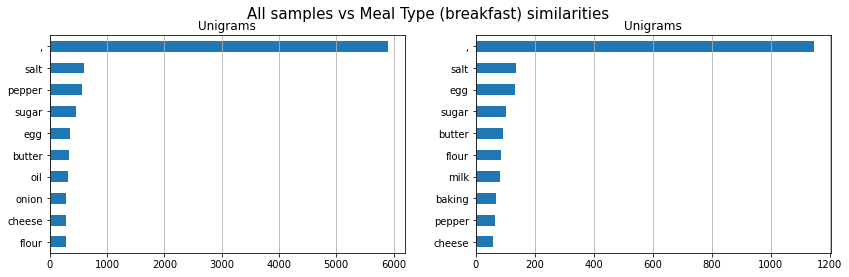

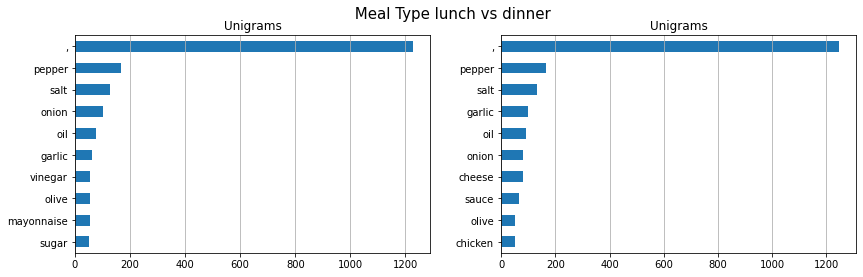

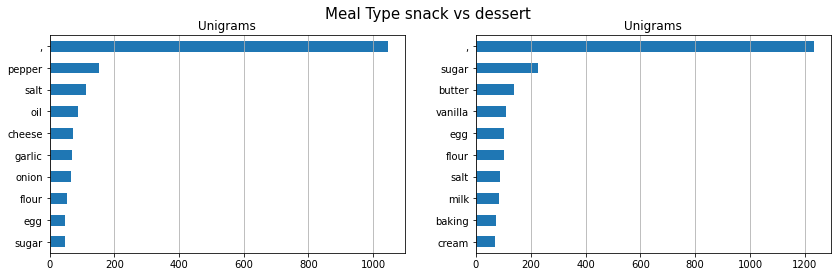

In [ ]:

nltk.download('punkt')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.suptitle("All samples vs Meal Type (breakfast) similarities", fontsize=15)
top=10

lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df_all['ingredients filtered text'])))

dic_ingredients_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_ingredients_freq.most_common(), 
                       columns=["Ingredients","Freq"])

dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)


lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df.loc[df_all['meal type'] == label_Meal_Type[0]]['ingredients filtered text'])))
dic_ingredients_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_ingredients_freq.most_common(), 
                       columns=["Ingredients","Freq"])
dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[1], 
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.suptitle(" Meal Type lunch vs dinner ", fontsize=15)

lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df.loc[df_all['meal type'] == label_Meal_Type[1]]['ingredients filtered text'])))
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Ingredients","Freq"])
dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)


lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df.loc[df_all['meal type'] == label_Meal_Type[2]]['ingredients filtered text'])))
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Ingredients","Freq"])
dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[1], 
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.suptitle("Meal Type snack vs dessert", fontsize=15)

lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df.loc[df_all['meal type'] == label_Meal_Type[3]]['ingredients filtered text'])))
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Ingredients","Freq"])
dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
lst_tokens = nltk.tokenize.word_tokenize(' '.join(np.array(df.loc[df_all['meal type'] == label_Meal_Type[4]]['ingredients filtered text'])))
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Ingredients","Freq"])
dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[1], 
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)

plt.show()


In [ ]:

for input, prediction, label in zip(X_test, predicted, y_test):
  if prediction != label:
    input_title = str(list(df[df['ingredients text'] == input]['title'])[0])
    ingre = str(list(df[df['ingredients text'] == input]['ingredients filtered'])[0][:5])
    print(input_title + '\t ' + ingre + '... \t classified as ', prediction, '\t should be ', label) 

    # fig, ax = plt.subplots()
    # fig.suptitle("Classified as " + str(prediction) + " and should be " + str(label), fontsize=15)

    # lst_tokens = nltk.tokenize.word_tokenize(input)
    # dic_words_freq = nltk.FreqDist(lst_tokens)
    # dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
    #                       columns=["Ingredients","Freq"])
    # dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
    #                   kind="barh", title="Unigrams", ax=ax, 
    #                   legend=False).grid(axis='x')
    # ax.set(ylabel=None)

Easy Homemade Pastrami	 ['garlic', 'vegetable oil', 'smoked paprika', 'mustard', 'pepper']... 	 classified as  dinner 	 should be  lunch
Sweet and Savory Slow Cooker Pulled Pork	 ['beer', 'sugar', 'salt', 'pepper', 'paprika']... 	 classified as  dinner 	 should be  lunch
Cheesecake-Stuffed Strawberries	 ['cream cheese', 'confectioner sugar', 'vanilla', 'strawberry hulled']... 	 classified as  dessert 	 should be  snack
Easy Batter Fruit Cobbler	 ['butter', 'flour', 'sugar', 'baking', 'salt']... 	 classified as  breakfast 	 should be  dessert
B and L's Strawberry Smoothie	 ['strawberry hulled', 'yogurt', 'sugar', 'vanilla']... 	 classified as  dessert 	 should be  breakfast
Baby Spinach Omelet	 ['egg', 'parmesan cheese', 'onion', 'nutmeg', 'salt']... 	 classified as  snack 	 should be  breakfast
The World's Greatest Crab Recipe	 ['olive oil', 'butter', 'garlic']... 	 classified as  snack 	 should be  lunch
Thai Chicken Spring Rolls	 ['ginger', 'garlic', 'soy sauce', 'chicken half', 'pea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


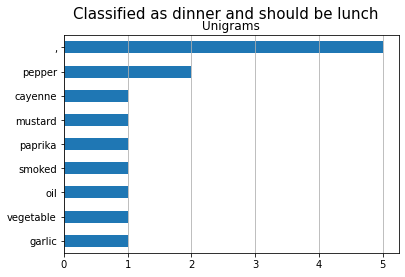

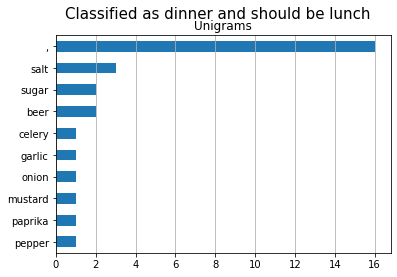

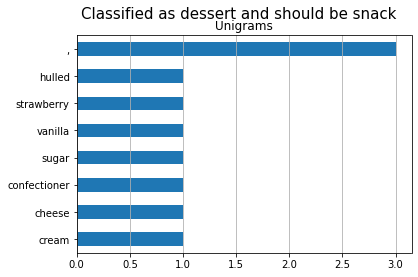

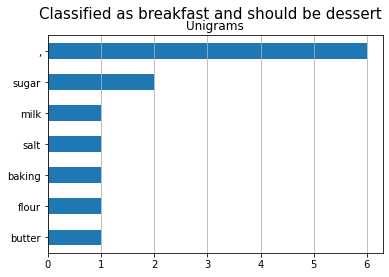

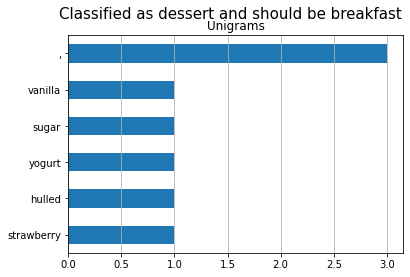

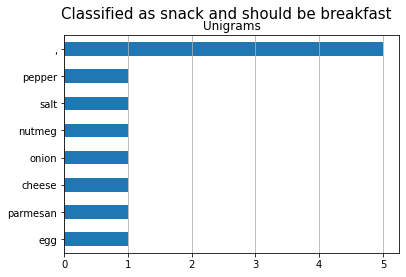

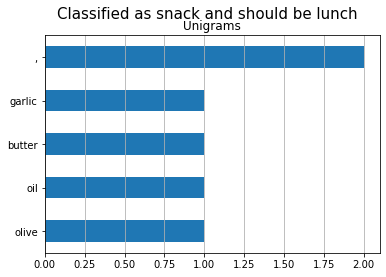

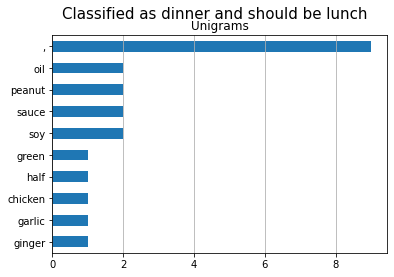

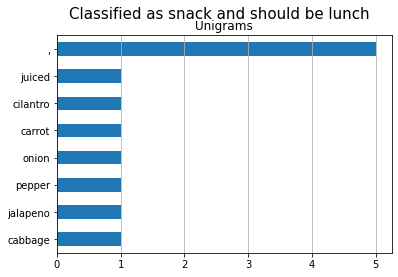

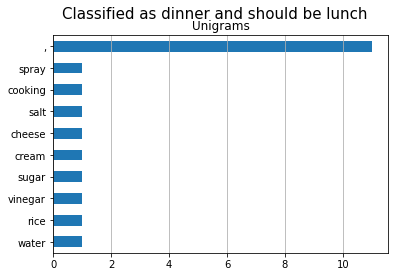

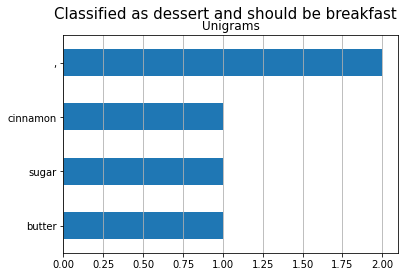

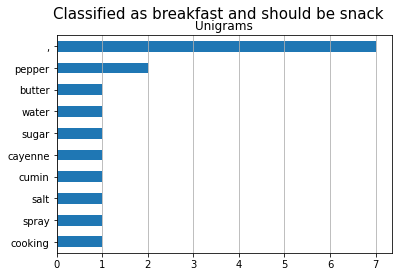

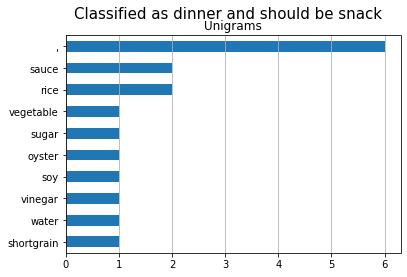

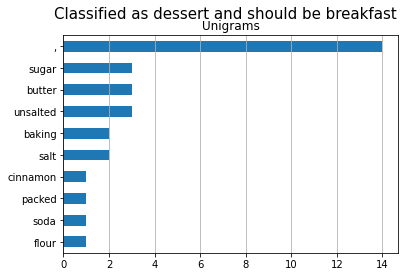

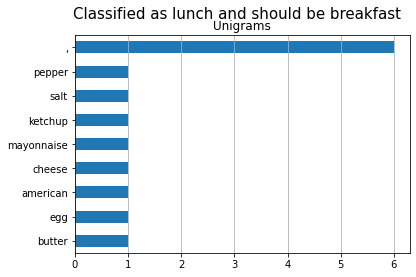

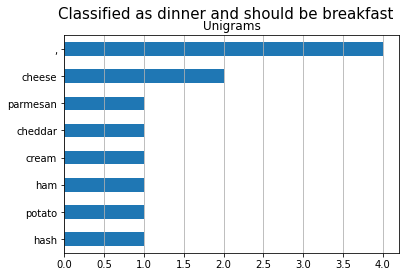

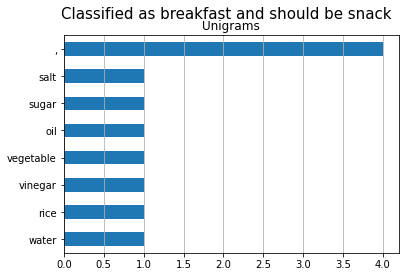

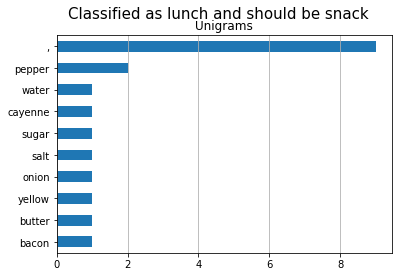

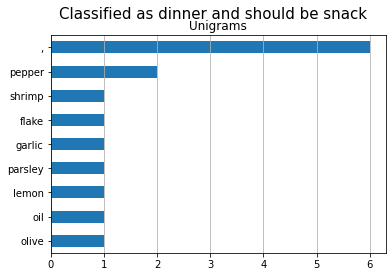

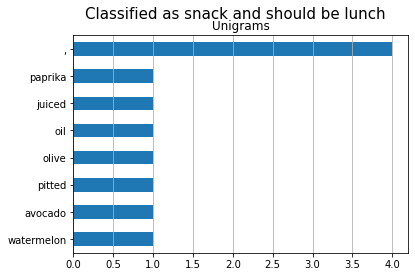

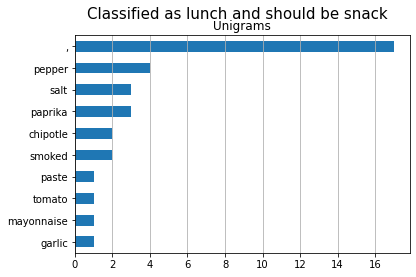

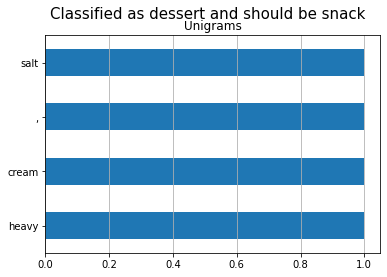

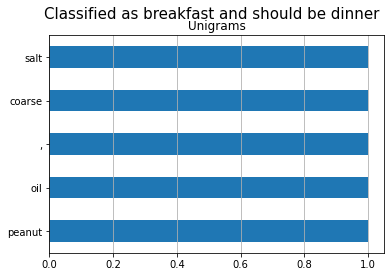

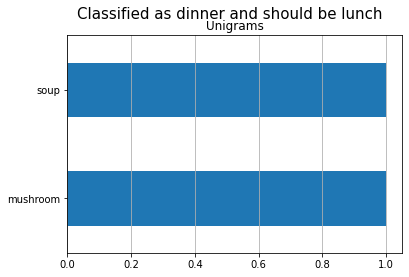

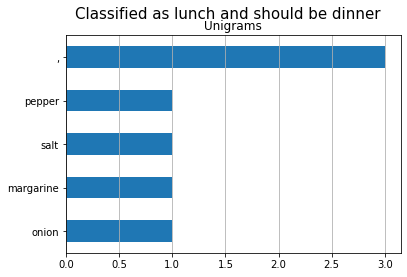

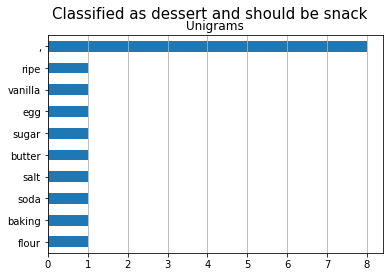

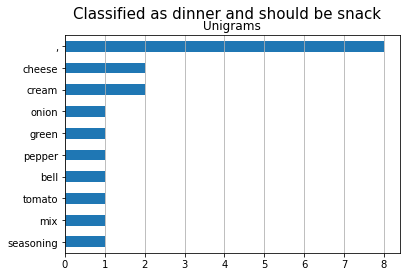

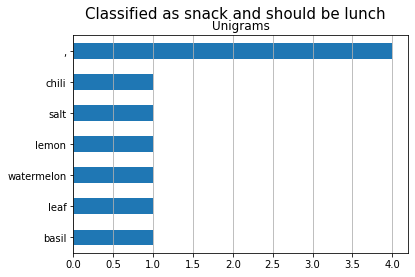

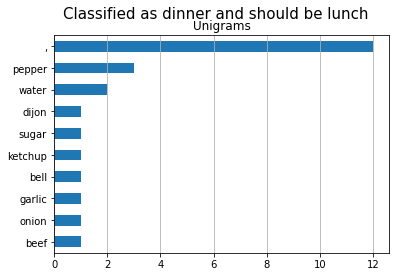

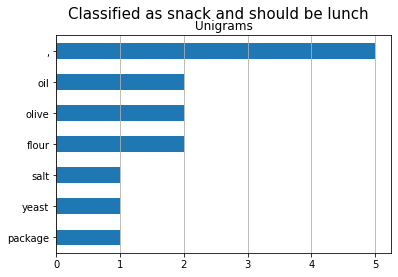

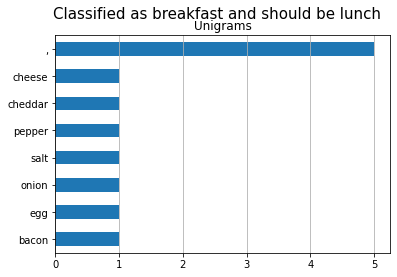

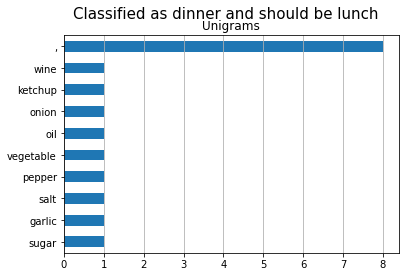

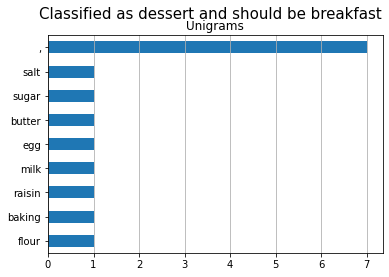

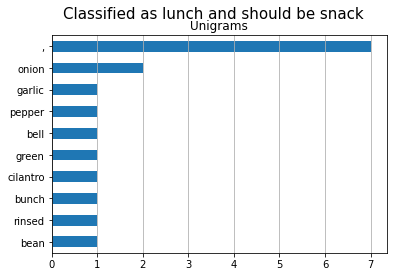

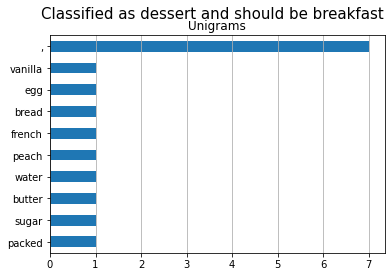

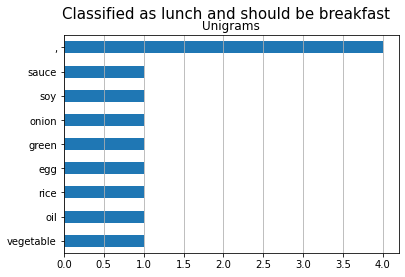

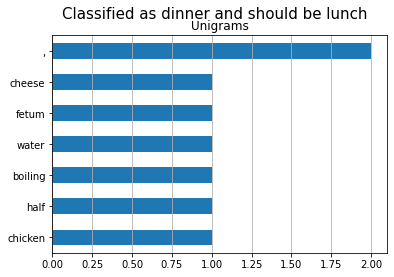

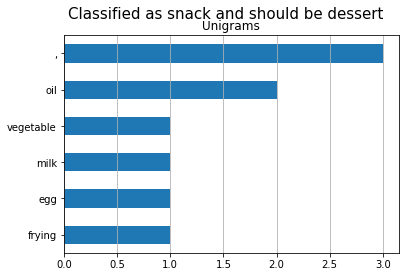

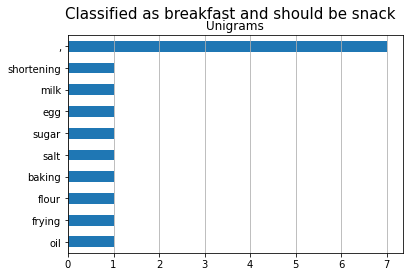

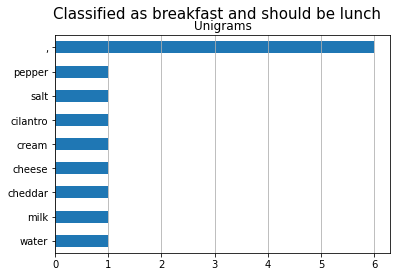

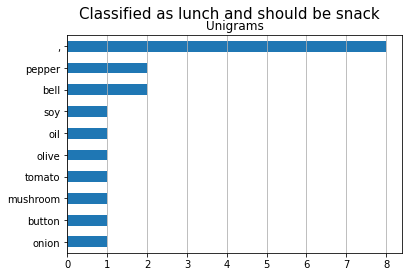

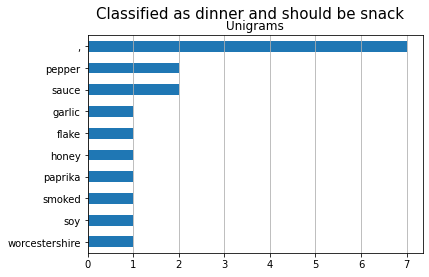

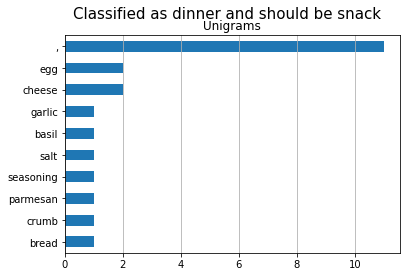

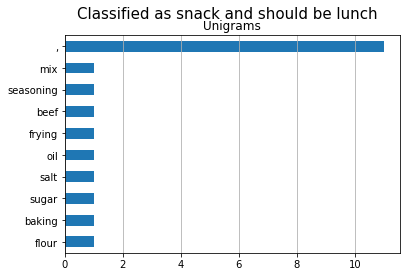

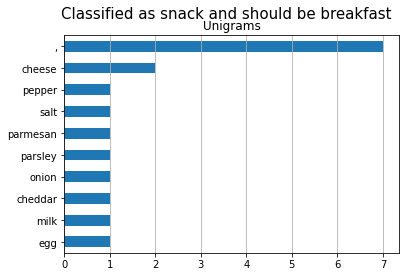

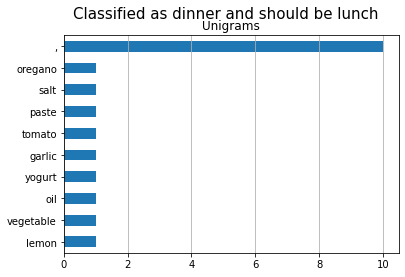

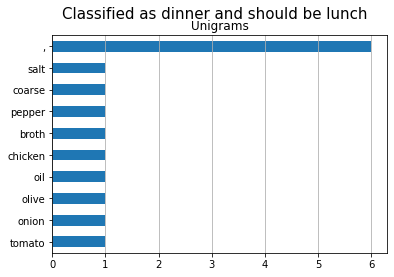

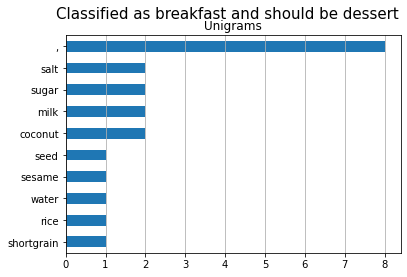

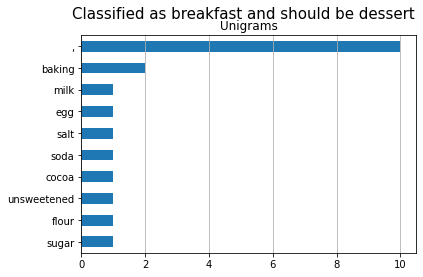

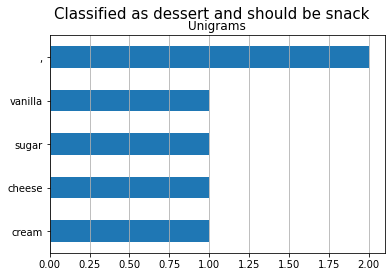

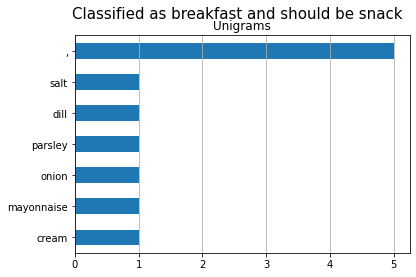

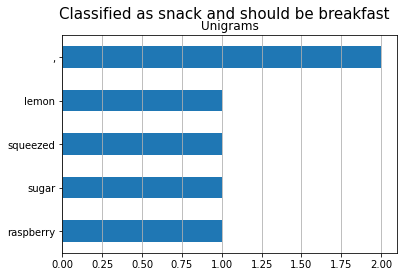

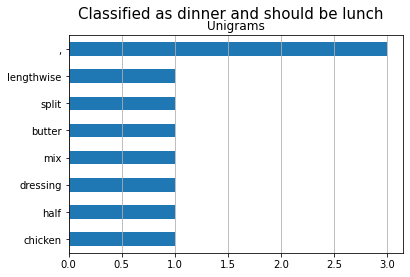

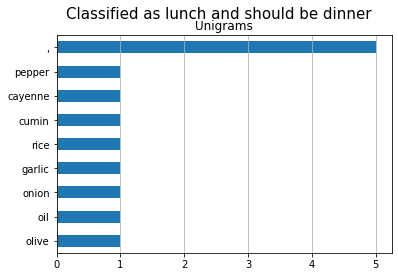

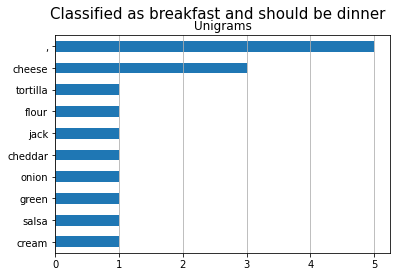

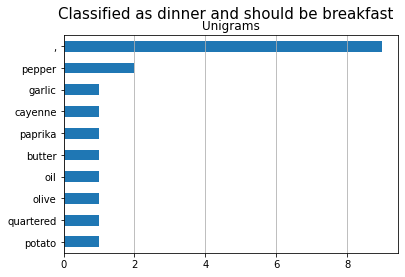

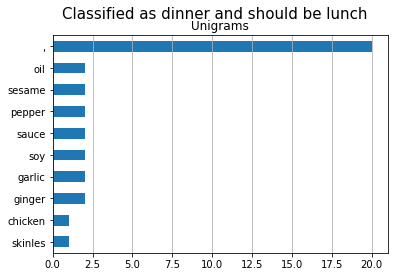

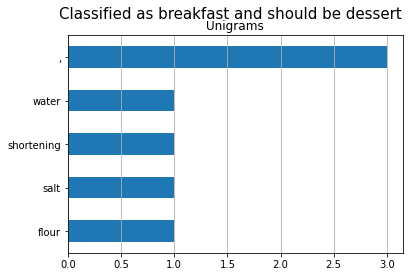

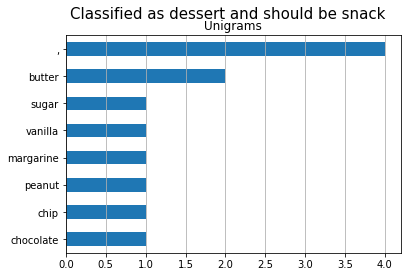

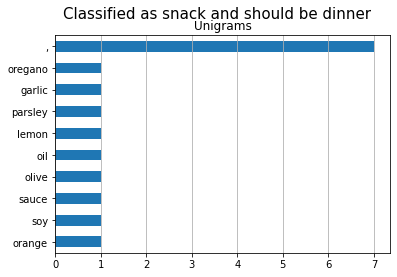

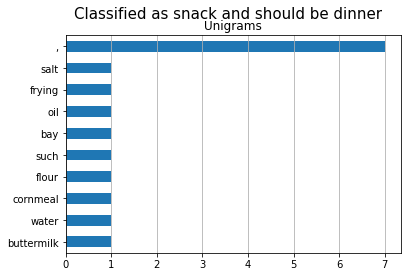

In [ ]:

for input, prediction, label in zip(X_test, predicted, y_test):
  if prediction != label:
    input_title = str(list(df[df['ingredients text'] == input]['title'])[0])
    ingre = str(list(df[df['ingredients text'] == input]['ingredients filtered'])[0][:5])
    # print(input_title + '\t ' + ingre + '... \t classified as ', prediction, '\t should be ', label) 

    fig, ax = plt.subplots()
    fig.suptitle("Classified as " + str(prediction) + " and should be " + str(label), fontsize=15)

    lst_tokens = nltk.tokenize.word_tokenize(str(list(df[df['ingredients text'] == input]['ingredients filtered text'])[0]))
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Ingredients","Freq"])
    dtf_uni.set_index("Ingredients").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Unigrams", ax=ax, 
                      legend=False).grid(axis='x')
    ax.set(ylabel=None)